# Pitney Bowes Meters Failure Prediction by Historical Data Performance

# Environment Set Up

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [3]:
# pip install pydot
# pip install pydotplus
import pydotplus

In [4]:
import datetime
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
import pydot
from IPython.display import Image
import matplotlib.pyplot as plt
%matplotlib inline

# Data Collection

In [5]:
# Read train file
df=pd.read_csv('train updated 04132022.csv')
df.head(5)

,deviceid,avg_time_charging_lag1,avg_time_charging_lag2,avg_time_charging_lag3,avg_time_charging_lag7,charging_rate_lag3,charging_rate_lag7,avg_time_discharging_lag1,avg_time_discharging_lag2,avg_time_discharging_lag3,...,number_times_restart,avg_volt_change_charging,avg_volt_change_discharging,avg_time_charging,avg_time_discharging,max_voltage_day,piececount,cycle_time,LastRecord,Date Deployed
0,28647,5.12,41.11,6.56,25.39,0.086667,-0.006667,4.37,91.70,15.70,...,2.375000,377.080000,367.428750,21.696250,39.005000,4174.875000,14.200000,60.701250,4/1/21,10/6/19
1,36175,36.60,5.16,6.23,6.96,0.136667,-1.296667,62.67,6.53,6.16,...,1.000000,350.517857,350.309286,19.883571,32.213571,4161.000000,19.777778,52.097143,4/1/21,10/27/19
2,16107,5.51,5.04,4.52,5.96,-0.460000,-0.083333,5.13,5.65,4.14,...,4.095238,346.113333,343.409524,13.675238,20.471429,4152.238095,19.200000,34.146667,4/1/21,10/31/19
3,27362,4.66,39.85,35.76,40.69,0.076667,-0.006667,3.93,76.37,60.86,...,0.736842,356.184211,349.844737,16.306842,26.189474,4164.631579,23.625000,42.496316,4/1/21,10/1/19
4,19463,5.10,43.24,4.63,5.26,0.040000,-0.153333,4.69,71.44,3.80,...,1.133333,370.904000,367.730000,18.797333,30.812000,4169.800000,12.666667,49.609333,4/1/21,9/13/19


In [6]:
df.shape

(40500, 55)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40500 entries, 0 to 40499
Data columns (total 55 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   deviceid                     40500 non-null  int64  
 1   avg_time_charging_lag1       40500 non-null  float64
 2   avg_time_charging_lag2       40500 non-null  float64
 3   avg_time_charging_lag3       40500 non-null  float64
 4   avg_time_charging_lag7       40434 non-null  float64
 5   charging_rate_lag3           40500 non-null  float64
 6   charging_rate_lag7           40488 non-null  float64
 7   avg_time_discharging_lag1    40500 non-null  float64
 8   avg_time_discharging_lag2    40500 non-null  float64
 9   avg_time_discharging_lag3    40500 non-null  float64
 10  avg_time_discharging_lag7    40434 non-null  float64
 11  discharging_rate_lag3        40500 non-null  float64
 12  discharging_rate_lag7        40488 non-null  float64
 13  fail_7          

In [8]:
# Creating New Attribute Used_Days
df[['LastRecord','Date Deployed']] = df[['LastRecord','Date Deployed']].apply(pd.to_datetime)

In [9]:
df['used_days'] = df['LastRecord'] - df['Date Deployed']
df.head()

,deviceid,avg_time_charging_lag1,avg_time_charging_lag2,avg_time_charging_lag3,avg_time_charging_lag7,charging_rate_lag3,charging_rate_lag7,avg_time_discharging_lag1,avg_time_discharging_lag2,avg_time_discharging_lag3,...,avg_volt_change_charging,avg_volt_change_discharging,avg_time_charging,avg_time_discharging,max_voltage_day,piececount,cycle_time,LastRecord,Date Deployed,used_days
0,28647,5.12,41.11,6.56,25.39,0.086667,-0.006667,4.37,91.70,15.70,...,377.080000,367.428750,21.696250,39.005000,4174.875000,14.200000,60.701250,2021-04-01,2019-10-06,543 days
1,36175,36.60,5.16,6.23,6.96,0.136667,-1.296667,62.67,6.53,6.16,...,350.517857,350.309286,19.883571,32.213571,4161.000000,19.777778,52.097143,2021-04-01,2019-10-27,522 days
2,16107,5.51,5.04,4.52,5.96,-0.460000,-0.083333,5.13,5.65,4.14,...,346.113333,343.409524,13.675238,20.471429,4152.238095,19.200000,34.146667,2021-04-01,2019-10-31,518 days
3,27362,4.66,39.85,35.76,40.69,0.076667,-0.006667,3.93,76.37,60.86,...,356.184211,349.844737,16.306842,26.189474,4164.631579,23.625000,42.496316,2021-04-01,2019-10-01,548 days
4,19463,5.10,43.24,4.63,5.26,0.040000,-0.153333,4.69,71.44,3.80,...,370.904000,367.730000,18.797333,30.812000,4169.800000,12.666667,49.609333,2021-04-01,2019-09-13,566 days


In [10]:
df['used_days'] = pd.to_numeric(df['used_days'].dt.days, downcast='integer')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40500 entries, 0 to 40499
Data columns (total 56 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   deviceid                     40500 non-null  int64         
 1   avg_time_charging_lag1       40500 non-null  float64       
 2   avg_time_charging_lag2       40500 non-null  float64       
 3   avg_time_charging_lag3       40500 non-null  float64       
 4   avg_time_charging_lag7       40434 non-null  float64       
 5   charging_rate_lag3           40500 non-null  float64       
 6   charging_rate_lag7           40488 non-null  float64       
 7   avg_time_discharging_lag1    40500 non-null  float64       
 8   avg_time_discharging_lag2    40500 non-null  float64       
 9   avg_time_discharging_lag3    40500 non-null  float64       
 10  avg_time_discharging_lag7    40434 non-null  float64       
 11  discharging_rate_lag3        40500 non-nu

In [12]:
df.head()

,deviceid,avg_time_charging_lag1,avg_time_charging_lag2,avg_time_charging_lag3,avg_time_charging_lag7,charging_rate_lag3,charging_rate_lag7,avg_time_discharging_lag1,avg_time_discharging_lag2,avg_time_discharging_lag3,...,avg_volt_change_charging,avg_volt_change_discharging,avg_time_charging,avg_time_discharging,max_voltage_day,piececount,cycle_time,LastRecord,Date Deployed,used_days
0,28647,5.12,41.11,6.56,25.39,0.086667,-0.006667,4.37,91.70,15.70,...,377.080000,367.428750,21.696250,39.005000,4174.875000,14.200000,60.701250,2021-04-01,2019-10-06,543
1,36175,36.60,5.16,6.23,6.96,0.136667,-1.296667,62.67,6.53,6.16,...,350.517857,350.309286,19.883571,32.213571,4161.000000,19.777778,52.097143,2021-04-01,2019-10-27,522
2,16107,5.51,5.04,4.52,5.96,-0.460000,-0.083333,5.13,5.65,4.14,...,346.113333,343.409524,13.675238,20.471429,4152.238095,19.200000,34.146667,2021-04-01,2019-10-31,518
3,27362,4.66,39.85,35.76,40.69,0.076667,-0.006667,3.93,76.37,60.86,...,356.184211,349.844737,16.306842,26.189474,4164.631579,23.625000,42.496316,2021-04-01,2019-10-01,548
4,19463,5.10,43.24,4.63,5.26,0.040000,-0.153333,4.69,71.44,3.80,...,370.904000,367.730000,18.797333,30.812000,4169.800000,12.666667,49.609333,2021-04-01,2019-09-13,566


In [13]:
round(df.describe(),2)

,deviceid,avg_time_charging_lag1,avg_time_charging_lag2,avg_time_charging_lag3,avg_time_charging_lag7,charging_rate_lag3,charging_rate_lag7,avg_time_discharging_lag1,avg_time_discharging_lag2,avg_time_discharging_lag3,...,total_off_time,number_times_restart,avg_volt_change_charging,avg_volt_change_discharging,avg_time_charging,avg_time_discharging,max_voltage_day,piececount,cycle_time,used_days
count,40500.00,40500.00,40500.00,40500.00,40434.00,40500.00,40488.00,40500.00,40500.00,40500.00,...,40500.00,40500.00,40500.00,40500.00,40500.00,40500.00,40500.00,40500.00,40500.00,40500.00
mean,27511.16,16.27,16.52,16.28,16.36,-0.04,-0.05,25.80,26.35,25.90,...,25.26,2.15,351.42,348.21,16.35,26.08,4159.27,20.53,42.43,550.00
std,12992.65,15.37,15.43,15.31,15.14,0.78,0.76,29.24,29.46,29.27,...,37.04,2.22,12.75,13.28,3.55,6.81,11.31,16.46,10.32,22.16
min,5000.00,1.51,1.06,0.04,1.07,-76.95,-42.13,0.52,0.70,1.07,...,0.00,0.09,304.05,298.25,4.89,4.13,4112.45,1.00,9.02,405.00
25%,16234.75,4.91,4.92,4.90,4.90,-0.07,-0.10,4.20,4.21,4.20,...,3.57,1.05,342.77,339.27,13.91,21.42,4151.67,11.33,35.36,537.00
50%,27528.00,5.77,5.83,5.78,5.78,0.00,-0.00,5.86,5.92,5.85,...,17.10,1.47,351.11,347.91,16.20,25.77,4159.16,16.50,42.01,553.00
75%,38785.25,30.10,30.73,30.06,29.60,0.05,0.06,50.20,51.21,50.30,...,37.00,2.35,359.69,356.84,18.66,30.48,4166.80,24.29,49.12,566.00
max,49999.00,82.55,98.89,81.00,81.89,9.56,17.91,104.55,110.56,108.17,...,2013.00,38.00,410.96,420.49,34.02,60.75,4208.90,418.92,94.76,606.00


In [14]:
df.value_counts("fail_7")

fail_7
0    31099
1     9401
dtype: int64

In [15]:
# percentage of meters failed within 7 days
# 0 = did not fail, 1 = failed
round(df['fail_7'].value_counts(normalize = True) * 100, 2)

0    76.79
1    23.21
Name: fail_7, dtype: float64

# EDA (Exploratory Data Analysis)

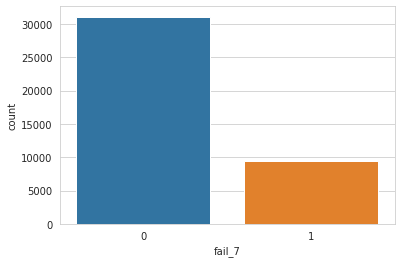

In [16]:
# graph counting failed and not failed
sns.set_style('whitegrid')
sns.countplot(x = 'fail_7', data = df)

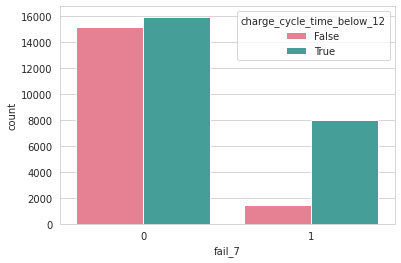

In [17]:
# a count plot for fail_7 column separated by charge_cycle_time_below_12
sns.countplot(x = 'fail_7', hue = 'charge_cycle_time_below_12', data = df, palette = 'husl')

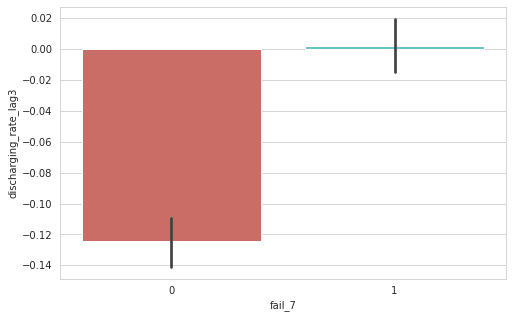

In [18]:
# bar plot — fail_7 vs discharging_rate_lag3
plt.figure(figsize = (8,5))
sns.barplot(x = 'fail_7', y = 'discharging_rate_lag3', data = df, palette = 'hls')

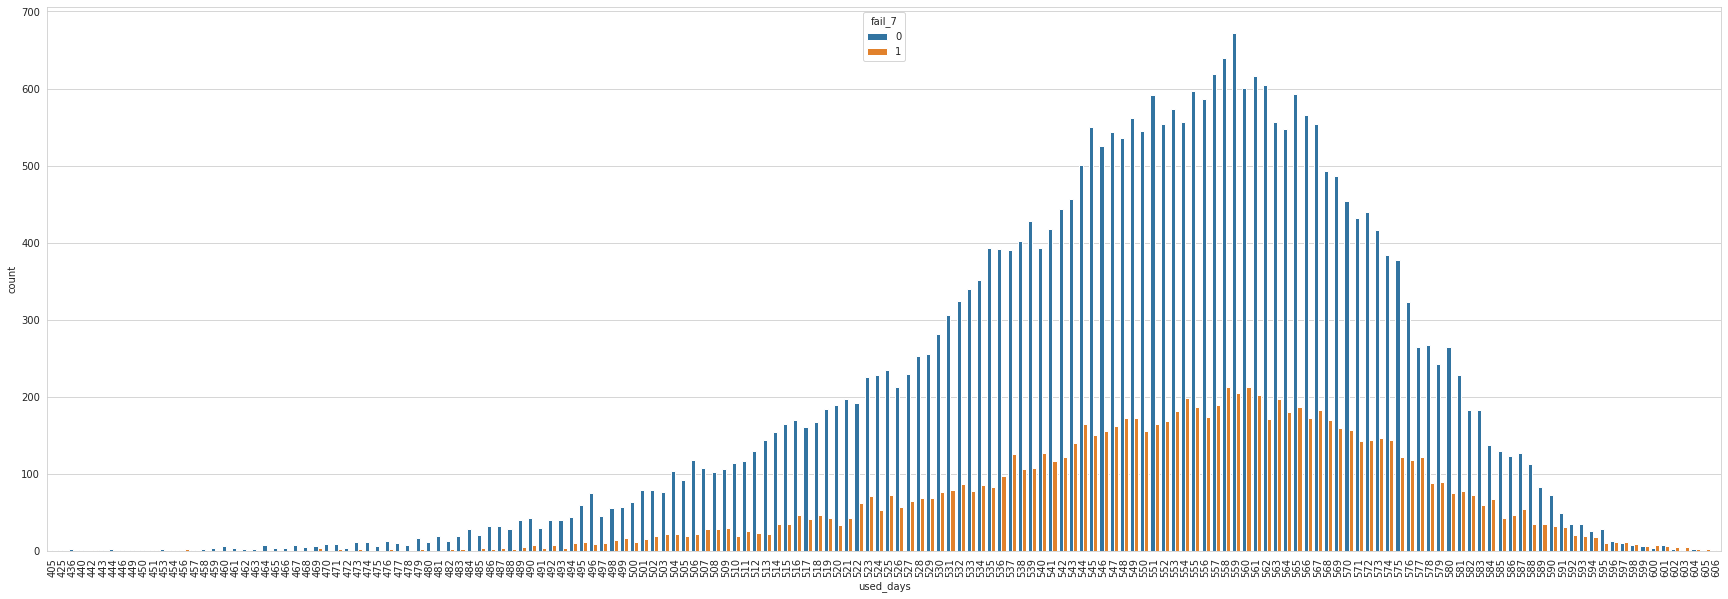

In [19]:
# display failed and not failed in different used_days
sns.set_style('whitegrid')
plt.figure(figsize = (30, 10))
plt.xticks(rotation = 90)
sns.countplot(x = 'used_days', hue = 'fail_7', data = df)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


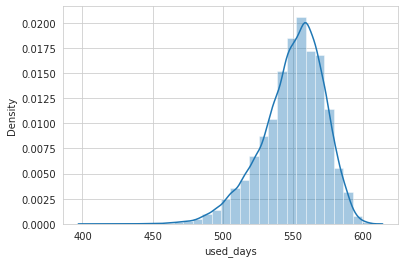

In [20]:
# distribution plot based on used_days
sns.distplot(df['used_days'], kde = True, bins = 30)

# Data Pre Processing

In [21]:
df.isnull().sum(axis = 0)

deviceid                          0
avg_time_charging_lag1            0
avg_time_charging_lag2            0
avg_time_charging_lag3            0
avg_time_charging_lag7           66
charging_rate_lag3                0
charging_rate_lag7               12
avg_time_discharging_lag1         0
avg_time_discharging_lag2         0
avg_time_discharging_lag3         0
avg_time_discharging_lag7        66
discharging_rate_lag3             0
discharging_rate_lag7            12
fail_7                            0
charge_cycle_time_below_12        0
avg_time_charging_lag4            0
avg_time_discharging_lag4         0
avg_time_charging_lag5            7
avg_time_discharging_lag5         7
avg_time_charging_lag6           28
avg_time_discharging_lag6        28
avg_time_charging_lag8          162
avg_time_discharging_lag8       162
avg_time_charging_lag9          374
avg_time_discharging_lag9       374
avg_time_charging_lag10         797
avg_time_discharging_lag10      797
avg_time_charging_lag11     

In [22]:
# show the percentage of missing data
nan_percent = round(100 * (df.isnull().sum()/len(df)), 2)
nan_percent = nan_percent[nan_percent > 0].sort_values(ascending = False)
nan_percent

avg_time_discharging_lag14    16.46
avg_time_charging_lag14       16.46
avg_time_discharging_lag13    10.82
avg_time_charging_lag13       10.82
avg_time_discharging_lag12     6.81
avg_time_charging_lag12        6.81
avg_time_charging_lag11        3.92
avg_time_discharging_lag11     3.92
avg_time_charging_lag10        1.97
avg_time_discharging_lag10     1.97
avg_time_discharging_lag9      0.92
avg_time_charging_lag9         0.92
avg_time_charging_lag8         0.40
avg_time_discharging_lag8      0.40
avg_time_charging_lag7         0.16
avg_time_discharging_lag7      0.16
discharging_rate_lag8          0.08
avg_time_discharging_lag6      0.07
avg_time_charging_lag6         0.07
charging_rate_lag7             0.03
discharging_rate_lag7          0.03
avg_time_discharging_lag5      0.02
avg_time_charging_lag5         0.02
dtype: float64

In [23]:
df = df.dropna()
df.shape

(33832, 56)

In [24]:
#Prepare smaller data subset
sample = df.sample(n = 1000, random_state=11).reset_index(drop=True)
sample.head()

,deviceid,avg_time_charging_lag1,avg_time_charging_lag2,avg_time_charging_lag3,avg_time_charging_lag7,charging_rate_lag3,charging_rate_lag7,avg_time_discharging_lag1,avg_time_discharging_lag2,avg_time_discharging_lag3,...,avg_volt_change_charging,avg_volt_change_discharging,avg_time_charging,avg_time_discharging,max_voltage_day,piececount,cycle_time,LastRecord,Date Deployed,used_days
0,33132,12.65,5.23,4.41,4.70,-0.033333,0.000000,17.20,9.02,4.11,...,336.982727,328.134546,15.885000,24.583182,4148.545455,12.466667,40.468182,2021-04-01,2019-09-28,551
1,38997,31.32,5.68,38.38,4.58,0.060000,0.893333,61.33,6.32,65.78,...,352.932500,347.939000,20.854000,35.322000,4164.850000,11.833333,56.176000,2021-04-01,2019-09-24,555
2,25747,40.59,26.18,28.27,41.16,-0.146667,-0.416667,78.82,50.26,41.29,...,346.276667,342.993889,24.953333,41.463889,4150.055556,36.300000,66.417222,2021-04-01,2019-09-22,557
3,15751,5.46,22.22,4.41,45.27,2.116667,-1.286667,5.41,33.34,4.16,...,343.235263,345.003684,18.090526,29.076842,4154.842105,4.750000,47.167368,2021-04-01,2019-08-27,583
4,26700,35.95,35.56,10.87,4.43,-0.406667,0.560000,48.52,63.61,13.49,...,358.899583,355.918750,18.535833,30.361667,4160.250000,21.166667,48.897500,2021-04-01,2019-09-21,558


In [25]:
sample.shape

(1000, 56)

In [26]:
# drop LastRecord, Date Deployed, and fail_7 for training data set
sample = sample.drop(["LastRecord", "Date Deployed"], axis = 1)
labels = np.array(sample["fail_7"])
sample = sample.drop("fail_7", axis = 1)
feature_list = list(sample.columns)
sample.shape

(1000, 53)

# Model Building

# Random Forest and Decision Trees

In [27]:
# Split Train-test set
train_sample, test_sample, train_labels, test_labels = \
train_test_split(sample, labels, test_size = 0.25, random_state = 11)

In [28]:
# Instantiate Model. n = # of trees in the forest
rf = RandomForestRegressor(n_estimators=1000, random_state=11)
rf.fit(train_sample, train_labels)

RandomForestRegressor(n_estimators=1000, random_state=11)

In [29]:
# calculating the average model error
predictions = rf.predict(test_sample)
errors = abs(predictions - test_labels)
avg_model_error = round(np.mean(errors), 3)
print("Average model error:", avg_model_error, "degree.") 

Average model error: 0.314 degree.


In [30]:
# Desicion Tree Making
tree = rf.estimators_[5]
print(tree.tree_.max_depth)

12


In [31]:
def tree_graph_to_png(tree, feature_names, png_file_to_save):
    tree_str = export_graphviz(tree, feature_names=feature_names, 
                                     filled=True, out_file=None)
    graph = pydotplus.graph_from_dot_data(tree_str)  
    graph.write_png(png_file_to_save)

In [32]:
tree_graph_to_png(tree, feature_names=feature_list, 
                 png_file_to_save='tree.png')

In [33]:
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 4, random_state=11)
rf_small.fit(train_sample, train_labels)

RandomForestRegressor(max_depth=4, n_estimators=10, random_state=11)

In [34]:
tree_small = rf_small.estimators_[7]
print(tree_small.tree_.max_depth)

4


In [35]:
tree_graph_to_png(tree_small, feature_names=feature_list, 
                 png_file_to_save='tree_small.png')

In [36]:
#list the feature importance
importances = list(rf.feature_importances_)
feature_importances = pd.DataFrame([f for f in zip(feature_list, importances)], columns = ['Feature', 'Importance']).nlargest(25, 'Importance')
feature_importances.sort_values(by = 'Importance', inplace = True)
print(feature_importances)

                        Feature  Importance
31   avg_time_discharging_lag13    0.015301
40           charging_rate_lag6    0.015359
2        avg_time_charging_lag2    0.015765
1        avg_time_charging_lag1    0.015798
5            charging_rate_lag3    0.016530
39           charging_rate_lag5    0.016650
23    avg_time_discharging_lag9    0.016817
18       avg_time_charging_lag6    0.016891
44         number_times_restart    0.017156
46  avg_volt_change_discharging    0.017339
20       avg_time_charging_lag8    0.017703
17    avg_time_discharging_lag5    0.017983
32      avg_time_charging_lag14    0.018117
6            charging_rate_lag7    0.018504
37        discharging_rate_lag8    0.018574
38           charging_rate_lag4    0.019656
45     avg_volt_change_charging    0.020425
15    avg_time_discharging_lag4    0.020575
14       avg_time_charging_lag4    0.024713
7     avg_time_discharging_lag1    0.024755
50                   piececount    0.029270
52                    used_days 

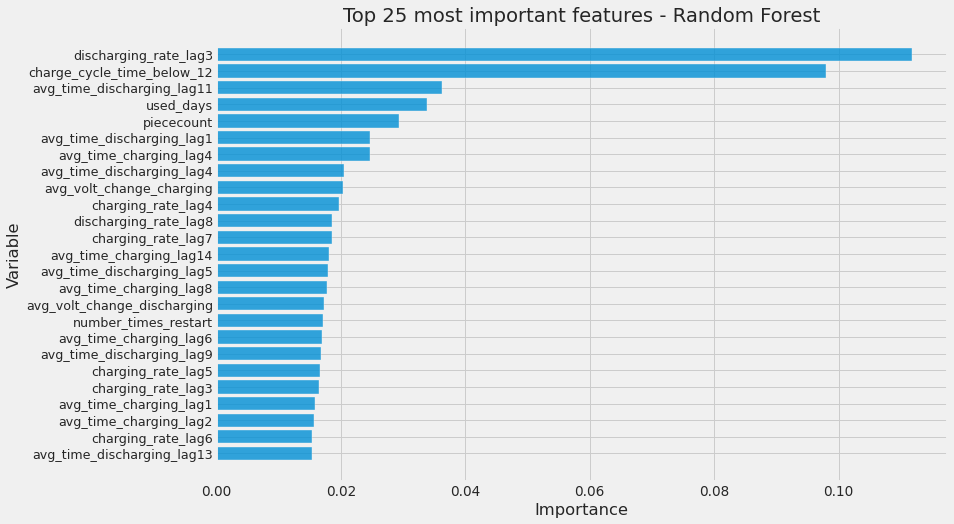

In [37]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8), dpi = 70)
y_values = range(len(feature_importances))
plt.barh(y_values, feature_importances.Importance, align = 'center', alpha = 0.8)
plt.yticks(y_values, feature_importances.Feature,fontsize=13)
plt.xlabel('Importance')
plt.ylabel('Variable')
plt.title('Top 25 most important features - Random Forest')
plt.savefig('Variable Importances.png', bbox_inches="tight")

In [38]:
# New random forest with only the top 25 important variables
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=11)
train_important = train_sample[feature_importances.Feature]
test_important = test_sample[feature_importances.Feature]
rf_most_important.fit(train_important, train_labels)
predictions = rf_most_important.predict(test_important)
errors = abs(predictions - test_labels)
print('Average (important features only) model error:', round(np.mean(errors), 3), 'degrees.')

Average (important features only) model error: 0.311 degrees.


# Logistic Regression

In [39]:
#Use logisticRegression to predict which machine will be fail in next 7 days
model = LogisticRegression(max_iter = 200)
model.fit(train_important, train_labels)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(max_iter=200)

In [40]:
predictions = model.predict(test_important)
print(predictions)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [41]:
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

           0       0.77      0.99      0.87       186
           1       0.90      0.14      0.24        64

    accuracy                           0.78       250
   macro avg       0.84      0.57      0.56       250
weighted avg       0.80      0.78      0.71       250



In [42]:
confusion_matrix(test_labels, predictions)

array([[185,   1],
       [ 55,   9]])

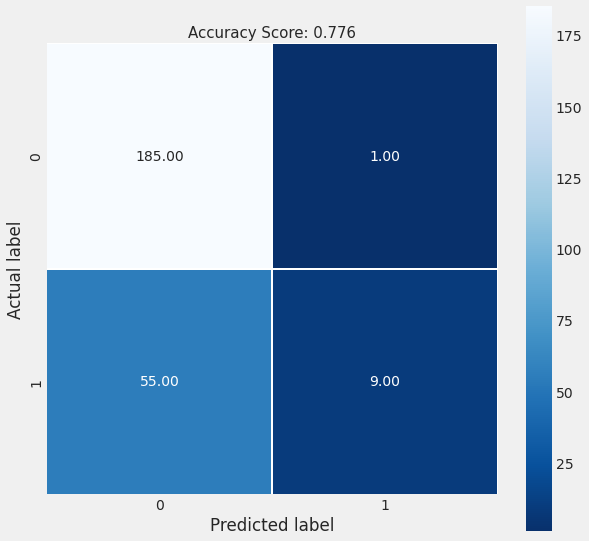

In [43]:
#making confusion matrix
plt.figure(figsize = (9,9))
sns.heatmap(confusion_matrix(test_labels, predictions), annot = True, fmt = '.2f', linewidths = 0.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
sample_title = 'Accuracy Score: {}'.format(accuracy_score(test_labels, predictions))
plt.title(sample_title, size = 15)
plt.savefig('Accuracy Score.png', bbox_inches="tight")

# Deployment

In [44]:
df_test = pd.read_csv("test_for_submissions.csv")
df_test.head()

,deviceid,avg_time_charging_lag1,avg_time_charging_lag2,avg_time_charging_lag3,avg_time_charging_lag7,charging_rate_lag3,charging_rate_lag7,avg_time_discharging_lag1,avg_time_discharging_lag2,avg_time_discharging_lag3,...,number_times_restart,avg_volt_change_charging,avg_volt_change_discharging,avg_time_charging,avg_time_discharging,max_voltage_day,piececount,cycle_time,LastRecord,Date Deployed
0,42979,35.56,4.31,5.07,4.60,-0.033333,0.040000,66.29,3.77,4.07,...,3.640000,346.301200,345.379600,17.481600,27.721600,4159.000000,12.437500,45.203200,4/1/21,9/8/19
1,14911,31.26,4.76,27.40,29.60,-0.076667,-0.060000,49.57,3.63,44.06,...,2.826087,356.218261,357.305652,17.479130,27.650435,4163.608696,34.818182,45.129565,4/1/21,9/13/19
2,48386,30.08,5.07,4.76,4.74,0.013333,-0.016667,52.96,5.16,4.05,...,1.266667,368.532667,366.844667,11.361333,16.739333,4176.133333,15.888889,28.100667,4/1/21,10/10/19
3,18822,33.31,32.79,5.09,4.96,0.000000,0.003333,49.26,68.54,5.83,...,0.937500,352.899375,352.595000,17.168750,27.460625,4159.875000,12.750000,44.629375,4/1/21,10/13/19
4,49810,4.44,30.03,5.57,5.02,-0.200000,-0.030000,4.16,54.80,4.52,...,1.200000,363.912800,365.208400,14.860000,23.980800,4168.400000,7.500000,38.840800,4/1/21,10/19/19


In [45]:
df_test.isnull().sum(0)

deviceid                         0
avg_time_charging_lag1           0
avg_time_charging_lag2           0
avg_time_charging_lag3           0
avg_time_charging_lag7           3
charging_rate_lag3               0
charging_rate_lag7               1
avg_time_discharging_lag1        0
avg_time_discharging_lag2        0
avg_time_discharging_lag3        0
avg_time_discharging_lag7        3
discharging_rate_lag3            0
discharging_rate_lag7            1
charge_cycle_time_below_12       0
avg_time_charging_lag4           0
avg_time_discharging_lag4        0
avg_time_charging_lag5           1
avg_time_discharging_lag5        1
avg_time_charging_lag6           2
avg_time_discharging_lag6        2
avg_time_charging_lag8          17
avg_time_discharging_lag8       17
avg_time_charging_lag9          43
avg_time_discharging_lag9       43
avg_time_charging_lag10        103
avg_time_discharging_lag10     103
avg_time_charging_lag11        182
avg_time_discharging_lag11     182
avg_time_charging_la

In [46]:
df_test[['LastRecord','Date Deployed']] = df_test[['LastRecord','Date Deployed']].apply(pd.to_datetime)
df_test['used_days'] = df_test['LastRecord'] - df_test['Date Deployed']
df_test['used_days'] = pd.to_numeric(df_test['used_days'].dt.days, downcast='integer')
df_test.head()

,deviceid,avg_time_charging_lag1,avg_time_charging_lag2,avg_time_charging_lag3,avg_time_charging_lag7,charging_rate_lag3,charging_rate_lag7,avg_time_discharging_lag1,avg_time_discharging_lag2,avg_time_discharging_lag3,...,avg_volt_change_charging,avg_volt_change_discharging,avg_time_charging,avg_time_discharging,max_voltage_day,piececount,cycle_time,LastRecord,Date Deployed,used_days
0,42979,35.56,4.31,5.07,4.60,-0.033333,0.040000,66.29,3.77,4.07,...,346.301200,345.379600,17.481600,27.721600,4159.000000,12.437500,45.203200,2021-04-01,2019-09-08,571
1,14911,31.26,4.76,27.40,29.60,-0.076667,-0.060000,49.57,3.63,44.06,...,356.218261,357.305652,17.479130,27.650435,4163.608696,34.818182,45.129565,2021-04-01,2019-09-13,566
2,48386,30.08,5.07,4.76,4.74,0.013333,-0.016667,52.96,5.16,4.05,...,368.532667,366.844667,11.361333,16.739333,4176.133333,15.888889,28.100667,2021-04-01,2019-10-10,539
3,18822,33.31,32.79,5.09,4.96,0.000000,0.003333,49.26,68.54,5.83,...,352.899375,352.595000,17.168750,27.460625,4159.875000,12.750000,44.629375,2021-04-01,2019-10-13,536
4,49810,4.44,30.03,5.57,5.02,-0.200000,-0.030000,4.16,54.80,4.52,...,363.912800,365.208400,14.860000,23.980800,4168.400000,7.500000,38.840800,2021-04-01,2019-10-19,530


In [47]:
test_for_submissions = df_test[feature_importances.Feature]
test_for_submissions[test_for_submissions.isnull().any(axis=1)]

,avg_time_discharging_lag13,charging_rate_lag6,avg_time_charging_lag2,avg_time_charging_lag1,charging_rate_lag3,charging_rate_lag5,avg_time_discharging_lag9,avg_time_charging_lag6,number_times_restart,avg_volt_change_discharging,...,charging_rate_lag4,avg_volt_change_charging,avg_time_discharging_lag4,avg_time_charging_lag4,avg_time_discharging_lag1,piececount,used_days,avg_time_discharging_lag11,charge_cycle_time_below_12,discharging_rate_lag3
7,NaN,0.383333,4.80,17.81,-0.080000,0.043333,5.20,9.39,1.500000,338.649000,...,0.056667,340.917000,3.50,4.69,25.22,6.800000,541,NaN,True,-0.123333
10,96.47,-0.560000,5.52,27.49,-0.013333,0.083333,4.18,9.62,2.714286,350.835714,...,-0.380000,352.864286,86.79,59.86,47.47,9.285714,541,72.00,True,-0.116667
14,NaN,0.020000,42.26,4.64,0.183333,0.060000,NaN,4.70,3.555556,346.518889,...,-0.026667,352.260000,5.83,6.08,4.59,15.400000,464,NaN,False,-0.706667
15,NaN,0.043333,5.04,34.33,-0.016667,-0.020000,53.35,5.11,2.461538,362.306923,...,0.430000,364.147692,5.84,5.04,64.75,14.900000,530,4.63,True,0.033333
21,NaN,0.006667,18.01,6.09,-0.140000,-1.836667,3.53,43.84,0.500000,359.310833,...,-0.090000,366.890833,29.67,18.21,6.24,8.250000,511,3.97,False,0.443333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4485,NaN,0.350000,39.61,34.73,-0.873333,-0.660000,16.67,33.41,0.666667,335.087500,...,0.600000,342.671667,40.25,24.81,56.75,20.000000,511,4.44,False,-0.893333
4489,NaN,0.243333,6.62,46.27,0.000000,-0.320000,4.55,5.04,1.166667,349.920833,...,-0.233333,355.165000,4.06,4.44,85.02,14.571429,586,45.57,True,-0.013333
4491,NaN,-0.053333,4.98,22.70,-0.980000,-0.020000,4.92,5.88,1.181818,348.303636,...,-0.173333,349.805454,74.62,42.99,46.07,7.000000,482,NaN,False,-0.720000
4494,NaN,-0.010000,24.98,24.79,-0.063333,0.970000,93.12,19.70,1.307692,339.469231,...,-0.496667,343.527692,47.36,25.69,42.25,17.428571,566,43.65,True,-0.370000


In [48]:
# Replace Null Data with Mean
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(test_for_submissions)

SimpleImputer()

In [49]:
test_for_submissions1 = pd.DataFrame(imp_mean.transform(test_for_submissions), columns = feature_importances.Feature)

In [50]:
test_for_submissions1.isnull().sum(axis = 0)

Feature
avg_time_discharging_lag13     0
charging_rate_lag6             0
avg_time_charging_lag2         0
avg_time_charging_lag1         0
charging_rate_lag3             0
charging_rate_lag5             0
avg_time_discharging_lag9      0
avg_time_charging_lag6         0
number_times_restart           0
avg_volt_change_discharging    0
avg_time_charging_lag8         0
avg_time_discharging_lag5      0
avg_time_charging_lag14        0
charging_rate_lag7             0
discharging_rate_lag8          0
charging_rate_lag4             0
avg_volt_change_charging       0
avg_time_discharging_lag4      0
avg_time_charging_lag4         0
avg_time_discharging_lag1      0
piececount                     0
used_days                      0
avg_time_discharging_lag11     0
charge_cycle_time_below_12     0
discharging_rate_lag3          0
dtype: int64

In [51]:
final_prediction = model.predict(test_for_submissions1)
print(final_prediction)

[0 0 0 ... 0 0 0]


In [52]:
final_prediction.sum()

196

In [53]:
# Export to excel as final prediction
df_test["predicted_fail_7"] = final_prediction
df_test_final = pd.DataFrame(df_test[['deviceid', 'predicted_fail_7']])
df_test_final.to_csv("team10_submission.csv", index=False)

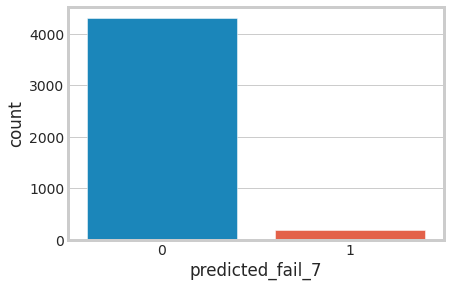

In [54]:
# count plot showing our predicted result
sns.set_style('whitegrid')
sns.countplot(x = 'predicted_fail_7', data = df_test_final)
plt.savefig('Predicted_Fail_7.png', bbox_inches="tight")